# **Importing all the required Libraries**

In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input"))

Using TensorFlow backend.


['dogs-vs-cats']


# **Define the constant values**

In [4]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# **Preparing the Training Data**

In [5]:
filenames = os.listdir("../input/dogs-vs-cats/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df.head()

,filename,category
0,dog.3501.jpg,1
1,dog.5601.jpg,1
2,dog.6569.jpg,1
3,dog.4515.jpg,1
4,cat.7291.jpg,0


In [7]:
df.tail()

,filename,category
24995,dog.1199.jpg,1
24996,dog.8549.jpg,1
24997,dog.1664.jpg,1
24998,dog.5495.jpg,1
24999,cat.12073.jpg,0


# **Respective counts of both categories**

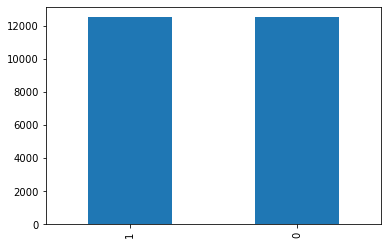

In [8]:
df['category'].value_counts().plot.bar()

# **Checking a sample image**

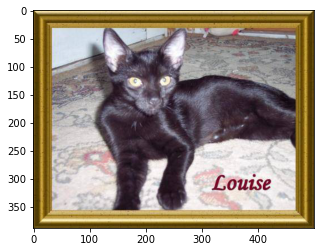

In [9]:
sample = random.choice(filenames)
image = load_img("../input/dogs-vs-cats/train/train/"+sample)
plt.imshow(image)

# **Impementing the Model**

**Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.**

**Conv Layer: This layer will extract features from image.**

**Pooling Layer: This layerreduce the spatial volume of input image after convolution.**

**Fully Connected Layer: It connect the network from a layer to another layer**

**Output Layer: It is the predicted values layer.**

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

# **Implementing Callbacks**

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# **Impementing EarlyStop**

This is to prevent overfitting so we will stop the learning after 10 epochs and val_loss value not decreased

In [12]:
earlystop = EarlyStopping(patience=10)

# **Learning Rate Reduction**

**We will reduce the learning rate when the accuracy would not increase for 2 continuous steps**

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

# **Preparing and Procesing the Data**

**Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.**

**So we will convert 1 to dog and 0 to cat**

In [15]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

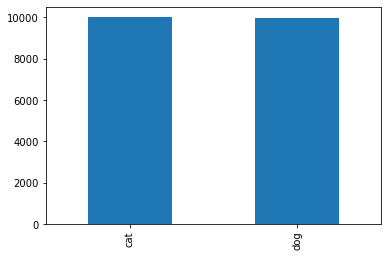

In [17]:
train_df['category'].value_counts().plot.bar()

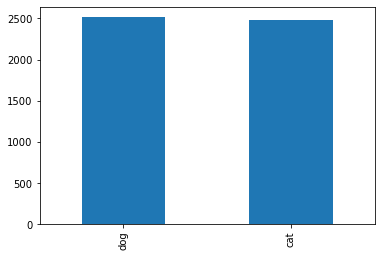

In [18]:
validate_df['category'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# **Training Generator**

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


# **Validation Generator**

In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# **Checking how our generator is working**

In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input/dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


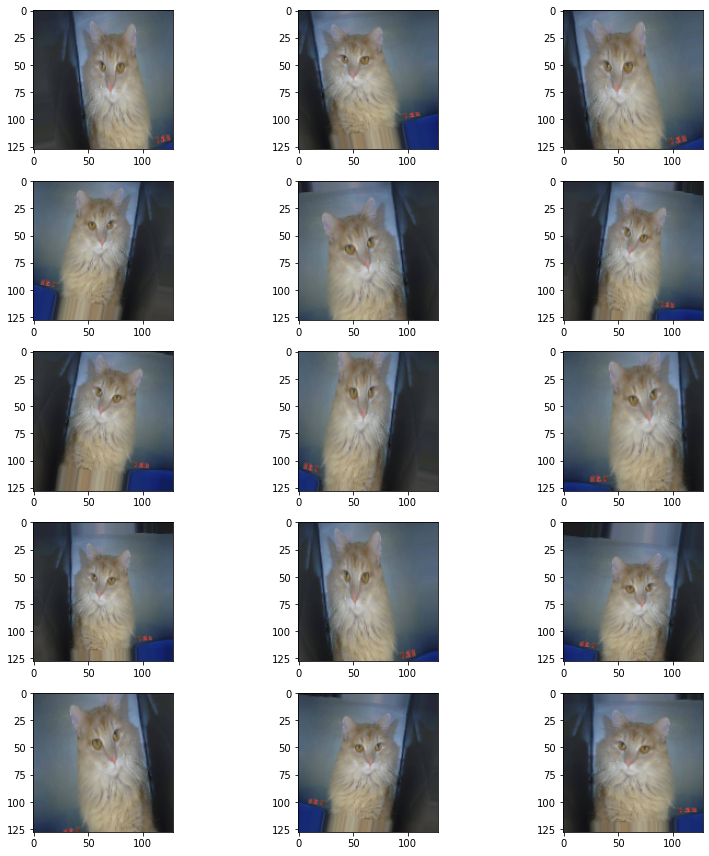

In [23]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# **Fitting the Model**

In [24]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 295s 221ms/step - loss: 0.7501 - accuracy: 0.6219 - val_loss: 0.6408 - val_accuracy: 0.6470 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - 255s 191ms/step - loss: 0.5600 - accuracy: 0.7198 - val_loss: 0.5194 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - 251s 188ms/step - loss: 0.5021 - accuracy: 0.7634 - val_loss: 0.6258 - val_accuracy: 0.7572 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - 251s 188ms/step - loss: 0.4605 - accuracy: 0.7859 - val_loss: 0.4456 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - 249s 187ms/step - loss: 0.4299 - accuracy: 0.8040 - val_loss: 0.4429 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 6/50
1333/1333 [==============================] - 251s 188ms/step - loss: 0.4171 - accuracy: 0.8120 - val_loss: 0.4579 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 7/50
1333/1333 [============

# **Save the model**

In [25]:
model.save_weights("model.h5")

# **Visualising the Training Metrics**

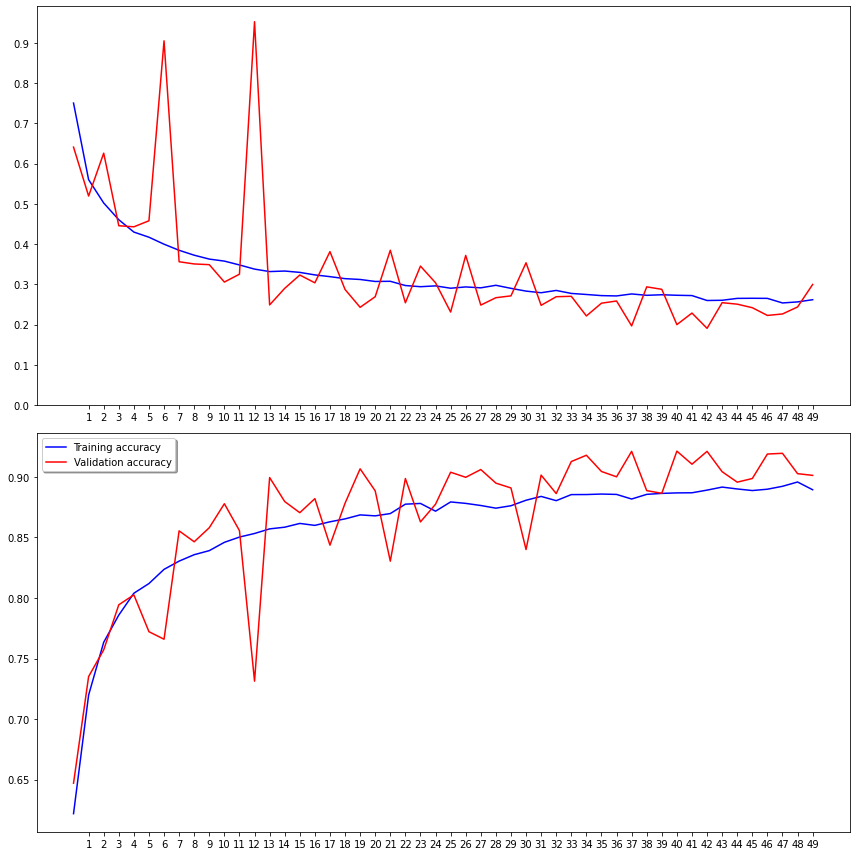

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# **Preparing the Test Data**

In [29]:
test_filenames = os.listdir("../input/dogs-vs-cats/test/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# **Create the Testing Generator**

In [30]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/dogs-vs-cats/test/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# **Prediction**

In [31]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [32]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [33]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [34]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

# **Visualising the Results**

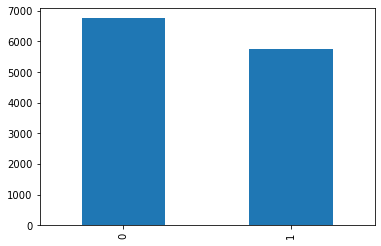

In [35]:
test_df['category'].value_counts().plot.bar()

**See the predicted results with images**

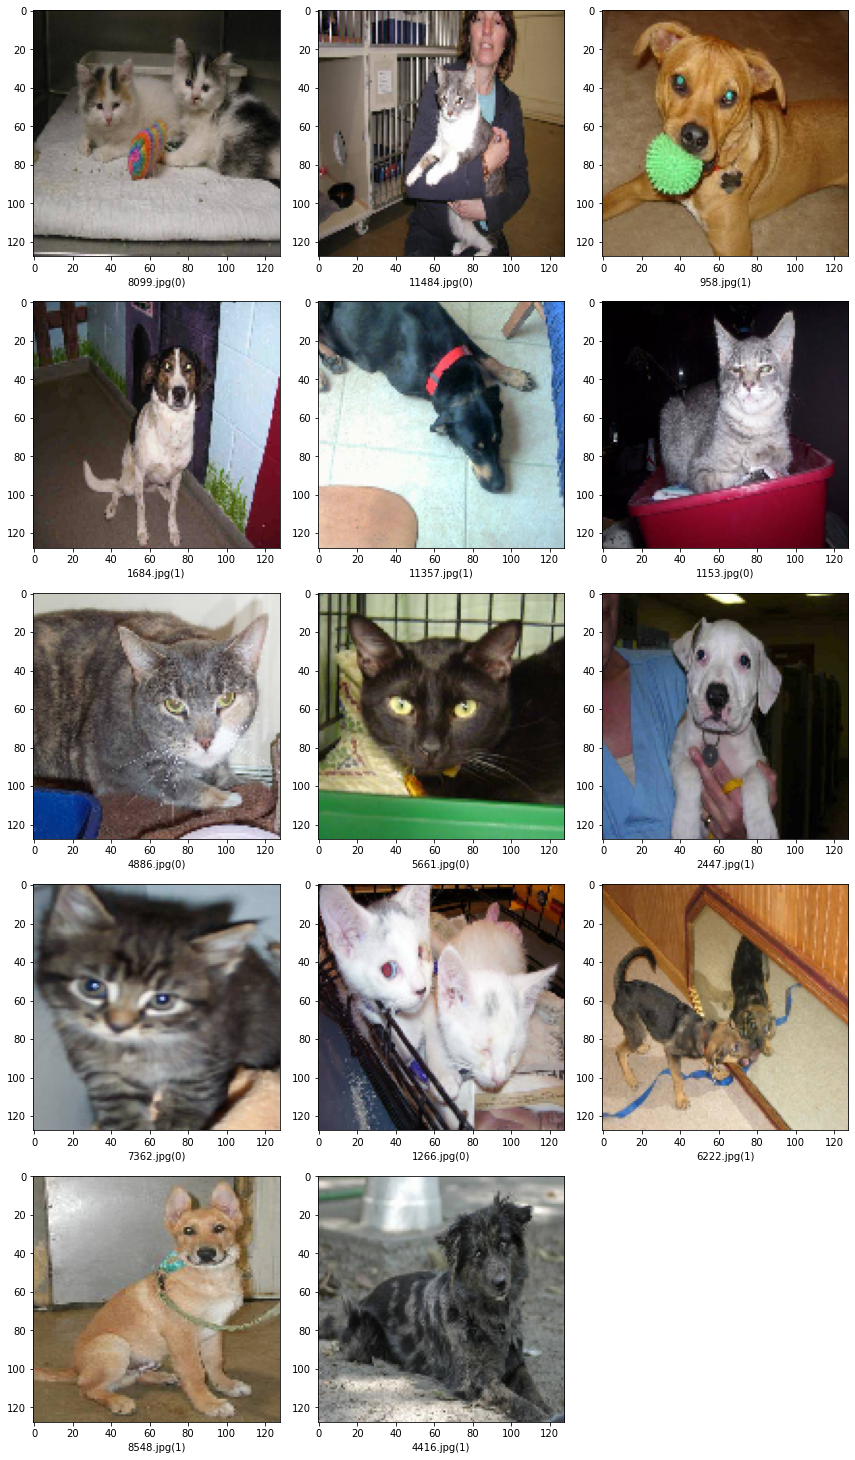

In [38]:
sample_test = test_df.head(14)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/dogs-vs-cats/test/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()